This notebook allows for comparison between fields using the parallel diffusion and reference fields using the linear stencil_1node code from the lecture. It has been used to compare the created fields and validate that the parallel version produces the same results within some margin. Depicted below is an example comparison.

In [110]:
import numpy as np
import matplotlib.pyplot as plt

In [111]:
out_field_reference = np.fromfile("output_folder/out_fields/out_field_reference_nHalo_5.dat")
out_field = np.fromfile("output_folder/out_fields/out_field_nNodes_5_nHalo_5.dat")

In [112]:
out_field_reference[3:].size

4194304

In [113]:
out_field[3:].size

4194304

In [114]:
diff = out_field - out_field_reference

In [115]:
np.abs(diff).max()

0.03492961163785502

In [116]:
diff.mean()

-2.2778262902270822e-06

In [117]:
diff.std()

0.0013448308545675768

In [118]:
np.where(np.abs(diff)>1e-2)[0]

array([1099839, 1099840, 1099841, ..., 3133116, 3133117, 3133118])

In [119]:
np.where(np.abs(diff)>1e-2)[0].size

20032

In [120]:
np.where(np.abs(diff)>3e-2)[0].size

4032

Here one can see that in general the values in the two fields are close to each other. There are however around 0.2% entries with a difference of more than 0.01. These discrepancies are most likely due to the fact that the diffusion is not fully applied to the halo points, in particular corners, but some of these halo points are still included in the MPI gathering process. 

To mitigate this, one could optimize the partitioner class for higher halo numbers and in particular implement scattering and gathering processes that don't include the halo corners. This could turn out to be non-trivial and will require a thorough testing campaign, which is beyond the scope of this investigation.

The code below was copied from the day2 exercises and shows that inspite of the sometimes non-vanishing differences the diffusion is working as expected in the parallelized version.

In [121]:
def read_field_from_file(filename, num_halo=None):
    (rank, nbits, num_halo, nx, ny, nz) = np.fromfile(filename, dtype=np.int32, count=6)
    offset = (3 + rank) * 32 // nbits
    data = np.fromfile(
        filename,
        dtype=np.float32 if nbits == 32 else np.float64,
        count=nz * ny * nx + offset,
    )
    if rank == 3:
        return np.reshape(data[offset:], (nz, ny, nx))
    else:
        return np.reshape(data[offset:], (ny, nx))


def validate_results():
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    in_field = read_field_from_file("output_folder/out_fields/out_field_reference_nHalo_5.dat")
    im1 = axs[0].imshow(
        in_field[in_field.shape[0] // 2, :, :], origin="lower", vmin=-0.1, vmax=1.1
    )
    fig.colorbar(im1, ax=axs[0])
    axs[0].set_title("Reference field")

    out_field = read_field_from_file("output_folder/out_fields/out_field_nNodes_5_nHalo_5.dat")
    im2 = axs[1].imshow(
        out_field[out_field.shape[0] // 2, :, :], origin="lower", vmin=-0.1, vmax=1.1
    )
    fig.colorbar(im2, ax=axs[1])
    axs[1].set_title("Parallelized field")

    plt.show()

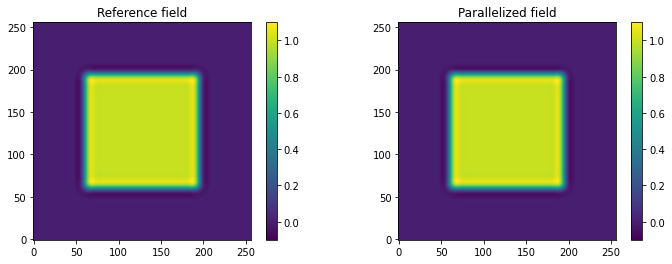

In [122]:
validate_results()